Из банка стали уходить клиенты. Задача: необходимо проанализировать исторические данные о поведении клиентов и расторжении договоров с банком и построить модель с предельно большим значением f1-меры (не менее 0,59).



Импортируем все, что нужно, и посмотрим на данные

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt
import numpy as np

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте
</div>


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
print(df.duplicated().sum())

0


In [ ]:
print(df['Gender'].unique())

['Female' 'Male']


Только в столбце tenure не все строки заполнены.

Два столбца имеют тип object.

Избавимся от того, что нам не нужно

In [ ]:
df = df.drop('Surname', axis=1)
df = df.drop('RowNumber', axis=1)
df = df.drop('CustomerId', axis=1)
df = df.drop('Geography', axis=1)



In [ ]:
df = df.dropna(subset=['Tenure'])

Переведем категориальные признаки в численные

In [ ]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [ ]:
print(df_ohe.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 10 columns):
CreditScore        9091 non-null int64
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
Gender_Male        9091 non-null uint8
dtypes: float64(3), int64(6), uint8(1)
memory usage: 719.1 KB
None


Разделим на тестовую, тренировочную и валидационную выборки

In [ ]:
df_ohe, test = train_test_split(df_ohe, test_size=0.2, train_size=0.8)
train, valid = train_test_split(df_ohe, test_size=0.25, train_size=0.75)

In [ ]:
features_test = test.drop('Exited', axis=1)
target_test = test['Exited']
features_train = train.drop('Exited', axis=1)
target_train = train['Exited']
features_valid = valid.drop('Exited', axis=1)
target_valid = valid['Exited']



Отмасштабируем данные

In [ ]:
numeric = ['Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 


In [ ]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 7622 to 9611
Data columns (total 10 columns):
CreditScore        1818 non-null int64
Age                1818 non-null int64
Tenure             1818 non-null float64
Balance            1818 non-null float64
NumOfProducts      1818 non-null int64
HasCrCard          1818 non-null int64
IsActiveMember     1818 non-null int64
EstimatedSalary    1818 non-null float64
Exited             1818 non-null int64
Gender_Male        1818 non-null uint8
dtypes: float64(3), int64(6), uint8(1)
memory usage: 143.8 KB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5454 entries, 4394 to 1013
Data columns (total 10 columns):
CreditScore        5454 non-null int64
Age                5454 non-null int64
Tenure             5454 non-null float64
Balance            5454 non-null float64
NumOfProducts      5454 non-null int64
HasCrCard          5454 non-null int64
IsActiveMember     5454 non-null int64
EstimatedSalary    5454 non-null float64
Exited             5454 non-null int64
Gender_Male        5454 non-null uint8
dtypes: float64(3), int64(6), uint8(1)
memory usage: 431.4 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 8450 to 7995
Data columns (total 10 columns):
CreditScore        1819 non-null int64
Age                1819 non-null int64
Tenure             1819 non-null float64
Balance            1819 non-null float64
NumOfProducts      1819 non-null int64
HasCrCard          1819 non-null int64
IsActiveMember     1819 non-null int64
EstimatedSalary    1819 non-null float64
Exited             1819 non-null int64
Gender_Male        1819 non-null uint8
dtypes: float64(3), int64(6), uint8(1)
memory usage: 143.9 KB


обучим разные модели, посмотрим на значения f1 и roc-auc

In [ ]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Decision Tree Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Decision Tree Classifier
F1 0.43513513513513513
Accuracy 0.77007700770077
Roc_auc 0.6516351178927865


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=15)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Random Forest Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Random Forest Classifier
F1 0.5191637630662022
Accuracy 0.8481848184818482
Roc_auc 0.8168578625293008


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Logistic Regression')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Logistic Regression
F1 0.2821576763485477
Accuracy 0.8096809680968097
Roc_auc 0.737217842875648


Доля accuracy во всех моделях высока, но непоказательна - это всего лишь доля правильных ответов. F1 - гармоническое среднее полноты и точности, показывает лучший результат в модели Random Forest clf.

## Борьба с дисбалансом

начнем с balanced

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Logistic Regression')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Logistic Regression
F1 0.4563758389261745
Accuracy 0.6881188118811881
Roc_auc 0.7400299465739137


In [ ]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Decision Tree Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Decision Tree Classifier
F1 0.4293785310734463
Accuracy 0.7777777777777778
Roc_auc 0.646653732543303


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=15, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Random Forest Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Random Forest Classifier
F1 0.5272407732864676
Accuracy 0.852035203520352
Roc_auc 0.8127542885552428


F1 опять же лучше в случайном лесе.

Увеличим выборку

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 
print('Logistic Regression')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Logistic Regression
F1 0.3867469879518072
Accuracy 0.44004400440044006
Roc_auc 0.7407329724984804


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=15)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 
print('Random Forest')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Random Forest
F1 0.5319148936170214
Accuracy 0.8305830583058306
Roc_auc 0.8045422854557143


In [ ]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 
print('Decision Tree Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Decision Tree Classifier
F1 0.4726735598227474
Accuracy 0.8036303630363036
Roc_auc 0.6713421774771469


И опять же F1 лучше в случайном лесе

Уменьшим выборку

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Logistic Regression')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Logistic Regression
F1 0.3810650887573965
Accuracy 0.42464246424642466
Roc_auc 0.740033830695044


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=15)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Random Forest Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Random Forest Classifier
F1 0.426829268292683
Accuracy 0.5346534653465347
Roc_auc 0.7939590264061975


In [ ]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Decision Tree Classifier')
print('F1', f1_score(target_valid, predicted_valid))
print('Accuracy', accuracy_score(target_valid, predicted_valid))
proba = model.predict_proba(features_valid)[:,1]
print('Roc_auc', roc_auc_score(target_valid, proba))

Decision Tree Classifier
F1 0.3979289940828402
Accuracy 0.5522552255225522
Roc_auc 0.633702130634646


Модель случйного леса опять побеждает

In [ ]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Матрица Decision Tree Cl') 
print(confusion_matrix(target_valid, predicted_valid))

Матрица Decision Tree Cl
[[1239  228]
 [ 190  161]]


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=15)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Матрица Random Forest Cl') 
print(confusion_matrix(target_valid, predicted_valid))

Матрица Random Forest Cl
[[1393   74]
 [ 202  149]]


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Матрица Logistic Regression') 
print(confusion_matrix(target_valid, predicted_valid))

Матрица Logistic Regression
[[1404   63]
 [ 283   68]]


In [ ]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Decision Tree Classifier')
print('Полнота', recall_score(target_valid, predicted_valid))
print('Точность', precision_score(target_valid, predicted_valid))

Decision Tree Classifier
Полнота 0.4586894586894587
Точность 0.4138817480719794


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=15)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Random Forest Classifier')
print('Полнота', recall_score(target_valid, predicted_valid))
print('Точность', precision_score(target_valid, predicted_valid))

Random Forest Classifier
Полнота 0.42450142450142453
Точность 0.6681614349775785


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Logistic Regression')
print('Полнота', recall_score(target_valid, predicted_valid))
print('Точность', precision_score(target_valid, predicted_valid))

Logistic Regression
Полнота 0.19373219373219372
Точность 0.5190839694656488


Precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

## Тестирование модели

F1 близка к нулю, если какой-либо из параметров (полнота или точность) плохо прогнозирует положительный класс (класс 1 - тот, что встречается реже). 


roc auc score получился 0,77, то есть модель работает достаточно хорошо, по крайней мере, лучше случайной. 

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=125, max_depth=11)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Random Forest Classifier')
print('F1', f1_score(target_test, predicted_test))

Random Forest Classifier
F1 0.5507745266781412


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=125, max_depth=11, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Random Forest Classifier')
print('F1', f1_score(target_test, predicted_test))

Random Forest Classifier
F1 0.5910364145658263


In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=125, max_depth=19)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test) 
print('Random Forest')
print('F1', f1_score(target_test, predicted_test))
proba = model.predict_proba(features_test)[:,1]
print('Roc_auc', roc_auc_score(target_test, proba))

Random Forest
F1 0.5685997171145686
Roc_auc 0.8272101715822875


In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=745, max_depth=25)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print('Random Forest Classifier')
print('F1', f1_score(target_test, predicted_test))
proba = model.predict_proba(features_test)[:,1]
print('Roc_auc', roc_auc_score(target_test, proba))

Random Forest Classifier
F1 0.4532803180914513
Roc_auc 0.8278743191326512


In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=745, max_depth=15)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Матрица Random Forest Cl') 
print(confusion_matrix(target_test, predicted_test))

Матрица Random Forest Cl
[[1395   52]
 [ 206  166]]


In [ ]:
print(classification_report(target_test, predicted_test, target_names=['not exited', 'exited']))

              precision    recall  f1-score   support

  not exited       0.87      0.96      0.92      1447
      exited       0.76      0.45      0.56       372

    accuracy                           0.86      1819
   macro avg       0.82      0.71      0.74      1819
weighted avg       0.85      0.86      0.84      1819



In [ ]:
proba = model.predict_proba(features_test)[:,1]
roc_auc_score(target_test, proba)

0.8414572976347059

In [ ]:
df_ohe['Exited'].value_counts() / df_ohe.shape[0]

0    0.796205
1    0.203795
Name: Exited, dtype: float64

In [ ]:
X = df_ohe.drop(['Exited'], axis=1)
y = df_ohe['Exited'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12345)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train) 
dummy_clf.score(X_test, y_test)

0.7948294829482948

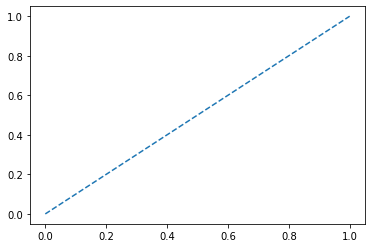

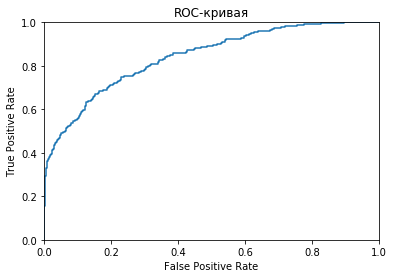

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=745, max_depth=15)
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
# ROC-кривая случайной модели выглядит как прямая
plt.plot([0, 1], [0, 1], linestyle='--')
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [ ]:

model = RandomForestClassifier(n_estimators=745, random_state=12345, max_depth=15)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1, 0.1):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test, predicted_test) 
    recall = recall_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.205, Полнота = 1.000, F1 = 0.340
Порог = 0.10 | Точность = 0.320, Полнота = 0.890, F1 = 0.471
Порог = 0.20 | Точность = 0.443, Полнота = 0.753, F1 = 0.558
Порог = 0.30 | Точность = 0.560, Полнота = 0.632, F1 = 0.593
Порог = 0.40 | Точность = 0.647, Полнота = 0.522, F1 = 0.577
Порог = 0.50 | Точность = 0.761, Полнота = 0.446, F1 = 0.563
Порог = 0.60 | Точность = 0.873, Полнота = 0.371, F1 = 0.521
Порог = 0.70 | Точность = 0.947, Полнота = 0.290, F1 = 0.444
Порог = 0.80 | Точность = 0.967, Полнота = 0.237, F1 = 0.380
Порог = 0.90 | Точность = 1.000, Полнота = 0.089, F1 = 0.163


При пороге 0,3 у нас максимальное значение F1 = 0,59

Итого:
1) был проведен анализ данных в отношении клиентов банка;

2) исследованы три модели: decision tree classifier, random forest classifier, logistic regression

3) проведена проверка данных моделей без учета дисбаланса

4) проведена проверка моделей с учетом дисбаланса

5) лучшее значение f1 показала модель Random Forest Classifier, на которой была проверена тестовая выборка

6) при пороге 0,3 f1 показывает лучшее значение - 0,59

7) при балансировке классов было достигнуто значение f1 - 0,59

8) модель работает.